# Predicting Dementia Stages

## Multi-label Image Classification *TensorFlow CNN*

---

**Objective:** Produce the capability to predict the stage of dementia in a patient using an MRI scan.

**Process:**
1. Source training data (labeled MRIs)
2. Load training data
3. Process & Explore training images
4. Build Convolutional Neural Network
5. Train CNN
6. Evaluate CNN
7. Tune CNN

Now that the training images have been sourced and saved in a structured directory, I can begin coding. First, I'll import all of the packages and libraries I'll be using for this model.

In [26]:
#----- Process images/training data
import numpy as np
import pandas as pd
import cv2
import glob
import matplotlib.pyplot as plt

#----- Build, Train, Evaluate CNN
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image

print('Imports complete.')

Imports complete.


--- 

### Loading Training Data

With all of the necessary packages imported, I'll begin to read in the images into arrays that can then be used to train a CNN. I'm creating a function that'll take file path arguments and returned the images in that directory as an array with image data and another with labels. The steps are as follows:

1. Initialize function to take two arguments
2. Initialize two empty arrays (image data and image label)
3. Use file path arguments to access directory
4. Process Image (read & resize)
5. Add image data and corresponding label to arrays
6. Return image datra and array of labels

In [27]:
# we're getting the set type as a string and stages as a list of strings for each dir name
def cv2_read_path_train(set_type, stages):
    ''' Processes images given the file path and naming conventions'''
    
    # list to hold image data - converted to numpy array on return
    image_array = []
    
    # list to hold labels - converted to numpy array on return
    label_array = []
    
    # Label encoding dictionary
    name_dict = {'NonDemented' : 0,
                 'VeryMildDemented' : 1,
                 'MildDemented' : 2,
                 'ModerateDemented' : 3}
    
    # Iterate through stages
    for stage in stages:
        # Iterate through every image in specified directory
        for filename in glob.glob(f'Alzheimers_Dataset/{set_type}/{stage}/*.jpg'):
            # Read image
            IMG_SIZE = 100
            img = cv2.imread(filename, cv2.COLOR_BGR2RGB)
            new_array = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            # Add image to list, SCALED
            image_array.append(new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)/255)
            # Add label
            label_array.append(name_dict[stage])

    return np.array(image_array)[:,0,:,:,:], np.array(label_array) 

---

### Process & Explore Training Images

First, I'll create a list that contains the stages of dementia as outlined in our directory (*the exact folder name*). I'm only grabbing the training data so I'll pass `'train'` along with my list of stages to the function created above.

In [28]:
# Name of dir for each stage
all_stages = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

# Create trainng sets
X_train, y_train = cv2_read_path_train(set_type='train', stages=all_stages)

In [29]:
X_train.shape, y_train.shape

((5121, 100, 100, 1), (5121,))

The shape of `X_train` shows that there are 5,121 training images with the size of 100x100. `y_train` is showing those same number of images but instead, it contains the labels for those images. I'll show this in a bit when I show a sample MRI scan from the dataset.

Next, I'll convert the `y_train` array of labels into a 2d array with binary identification of each label.

In [32]:
# convert labels to binary identification
train_labels = pd.Series(y_train)
y_train = pd.get_dummies(train_labels)

In [35]:
y_train.head()

,0,1,2,3
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


Now I'll do the same process for the testing images. These images will be used to evaulate the neural networks performance after being trained with the training images.

In [36]:
# Create testing sets
X_test, y_test = cv2_read_path_train(set_type='test', stages=all_stages)

# convert labels to binary identification
test_labels = pd.Series(y_test)
y_test = pd.get_dummies(test_labels)

To view sample images and their corresponding labels, I'm creating a function that'll show the MRI scan, the index at which the data for that scan was pulled from, and the label for the stage of dementia the specified MRI scan is classified as.

In [37]:
# Function to show image from dataset
def show_sample(data, index, label='Empty'):
     plt.imshow(data[index], cmap=plt.cm.plasma)
     plt.title(f"[{index}] : {label}")
     plt.show()

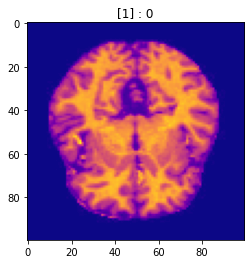

In [38]:
# View some TRAINING MRI scans
sample_label = np.argmax(y_train.iloc[1])
show_sample(X_train, 1, label=sample_label)

---

### Build Convolutional Neural Network

#### CNN Overview:

In [39]:
model = Sequential()

#-----Convolutional 2-Dimensional Layers
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", input_shape=(100, 100, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())

#-----Dense Layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

With the initial CNN structure built out, I'll look at a summary of my model.

In [40]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 98, 98, 64)        640       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 49, 49, 64)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 49, 49, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 47, 47, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 23, 23, 128)      0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 23, 23, 128)      

**Explain Summary**
**Explain compiling & args**

In [41]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

--- 

### Train CNN

In [ ]:
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=64)

---

### Evaluate CNN

In [13]:
vloss, vacc = model.evaluate(X_test, y_test)

40/40 [==============================] - 3s 78ms/step - loss: 0.8913 - accuracy: 0.5715


---

### Tune CNN